In [1]:
import os
import sys

# uncomment and replace with correct path if there are import errors
# sys.path.append("/path/to/surface-sampling/")
# sys.path.append("/path/to/NeuralForceField/")
# os.environ["LAMMPS_POTENTIALS"] = "/path/to/lammps/potentials/"
# os.environ["LAMMPS_COMMAND"] ="/path/to/lammps/src/lmp_serial"
# os.environ["ASE_LAMMPSRUN_COMMAND"] = os.environ["LAMMPS_COMMAND"]

from mcmc import MCMC
from mcmc.slab import initialize_slab

from ase.calculators.lammpsrun import LAMMPS # ase version of LAMMPS

from time import perf_counter


Initialize test slab and parameters

In [2]:
# initialize some parameters first
# Cu alat from https://www.copper.org/resources/properties/atomic_properties.html
Cu_alat = 3.6147
element = 'Cu'
slab = initialize_slab(Cu_alat, elem=element, size=(2, 2, 2), miller=(1, 0, 0))

surface_name = 'Cu(100)'
chem_pot = 0 # eV
alpha = 0.99 # slowly anneal
temp = 1.0 # in terms of kbT
num_sweeps = 50
sweep_size = 16

/home/dux/miniconda3/envs/surface_sampling/lib/python3.8/site-packages/catkit/gen/surface.py:334: UserWarning: Your slab has no bulk atoms and may be too thin to identify surface atoms correctly. This may cause surface adsorption site identification to fail.
  warnings.warn(


Set up LAMMPS (calculator)

In [3]:
# use LAMMPS
optimizer = 'LAMMPS'
parameters = {
    'pair_style': 'eam',
    'pair_coeff': ['* * Cu_u3.eam']
}

# set up the LAMMPS calculator
potential_file = os.path.join(os.environ["LAMMPS_POTENTIALS"], 'Cu_u3.eam')
lammps_calc = LAMMPS(files=[potential_file], keep_tmp_files=False, keep_alive=False, tmp_dir=os.path.join(os.path.expanduser('~'), "tmp_files"))
lammps_calc.set(**parameters)

{'pair_style': 'eam', 'pair_coeff': ['* * Cu_u3.eam']}

Perform MCMC and view results. Detailed results can be found in the corresponding run in the `Cu(100)/` folder.

2023-10-12 20:09:47,970|INFO|there are 8 atoms in pristine slab
2023-10-12 20:09:47,973|INFO|Running with num_sweeps = 50, temp = 1.0, pot = 0, alpha = 0.99
2023-10-12 20:09:47,975|INFO|using slab calc <ase.calculators.lammpsrun.LAMMPS object at 0x7fd112a8dc70>
2023-10-12 20:09:48,001|INFO|adsorbate(s) is(are) Cu
/home/dux/miniconda3/envs/surface_sampling/lib/python3.8/site-packages/catkit/gen/adsorption.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.r1_topology = np.array(self.r1_topology)
/home/dux/miniconda3/envs/surface_sampling/lib/python3.8/site-packages/catkit/gen/adsorption.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is d

temp list is:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


2023-10-12 20:09:49,597|INFO|optim structure has Energy = -41.07614427474785
2023-10-12 20:09:49,609|INFO|In sweep 2 out of 50
2023-10-12 20:09:50,840|INFO|optim structure has Energy = -47.30809646549419
2023-10-12 20:09:50,849|INFO|In sweep 3 out of 50
2023-10-12 20:09:52,156|INFO|optim structure has Energy = -44.38191789040059
2023-10-12 20:09:52,161|INFO|In sweep 4 out of 50
2023-10-12 20:09:53,465|INFO|optim structure has Energy = -47.30809646549421
2023-10-12 20:09:53,473|INFO|In sweep 5 out of 50
2023-10-12 20:09:54,794|INFO|optim structure has Energy = -47.30809646549421
2023-10-12 20:09:54,819|INFO|In sweep 6 out of 50
2023-10-12 20:09:56,334|INFO|optim structure has Energy = -47.30809646549421
2023-10-12 20:09:56,352|INFO|In sweep 7 out of 50
2023-10-12 20:09:57,909|INFO|optim structure has Energy = -47.30809646549421
2023-10-12 20:09:57,914|INFO|In sweep 8 out of 50
2023-10-12 20:09:59,224|INFO|optim structure has Energy = -47.30809646549421
2023-10-12 20:09:59,284|INFO|In sw

Time taken = 63.896227821707726 seconds


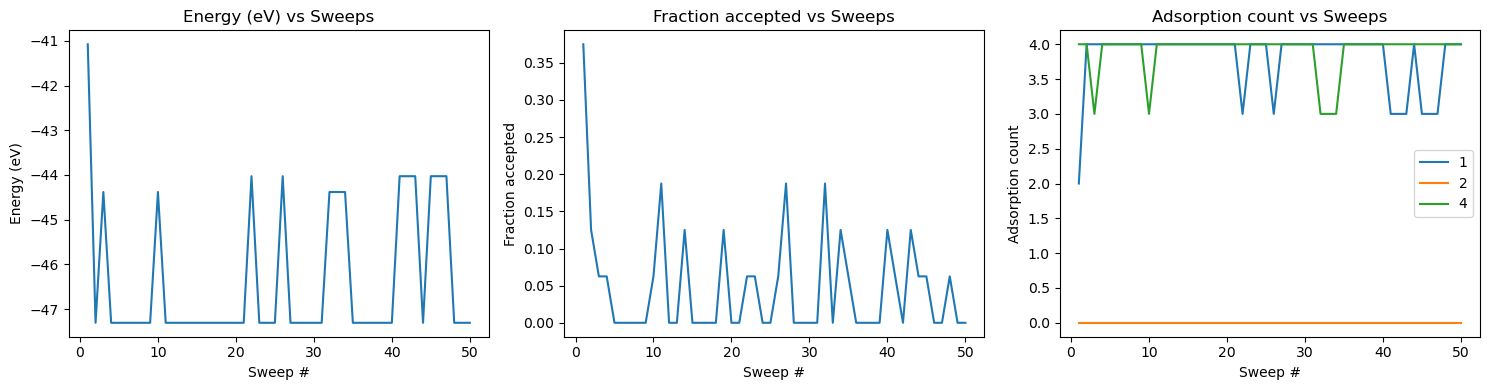

In [4]:
mcmc = MCMC(calc=lammps_calc, canonical=False, testing=False, surface_name=surface_name, 
            element=element, adsorbates=element, 
            relax=False, optimizer=optimizer) # no relaxation

start = perf_counter()
# call the main function
mcmc.mcmc_run(total_sweeps=num_sweeps,
    sweep_size=sweep_size,
    start_temp=temp,
    pot=chem_pot,
    alpha=alpha,
    slab=slab
    )

stop = perf_counter()
print(f"Time taken = {stop - start} seconds")